# Downstream analyses of single-cell ligand/receptor interactome
This notebook will report the analyses of cellPhoneDB results obtained by applying the said tool to a dataset we [previously produced](https://pubmed.ncbi.nlm.nih.gov/33575641/) by integrating existing resources ([Xin et al. 2016](https://pubmed.ncbi.nlm.nih.gov/27667665/), [Segerstolpe et al. 2016](https://pubmed.ncbi.nlm.nih.gov/27667667/) and [Lawlor et al. 2017](https://pubmed.ncbi.nlm.nih.gov/27864352/)). 

Briefly, two partitions of the single-cell integrated dataset were separately analysed, i.e.
1. Construction of ND and T2D interactomes
2. Interactions between cell-type pairs
3. Contrasting the T2D and ND interactomes
4. Network analysis of ND and T2D interactomes
5. The beta cell interactome in ND and T2D

The results of cellPhoneDB were then modelled as two separate graphs to compute centrality measures and other informative parameters, then these were compared to define features shared by T2D and ND, as well as the specific ones.

# Table of content

1. Construction of ND and T2D interactomes
2. Interactions between cell-type pairs

## 1) Construction of ND and T2D interactomes

### T2D

The first dataset to be analysed is T2D, the same steps will be repeated also for ND.

The dataframe is in a wide format with many NA values. Here the dataframe is reshaped (*melt*) to a long format, removing the null interactions. The interaction column is split in two, indicating the source and target cells of the interaction (*cell source*,*cell target*). The cell source is defined as the one not expressing the receptor (e.g. receptor_a: False), while the cell target is defined as the one expressing the receptor (e.g. receptor_b: True). In case that the receptor_a and receptor_b variables are both true or false, the interaction will not be directed (this information is stored in the column isDirected). This table corresponds to **Supplementary Table 1** in the manuscript.

The reported results indicate a total of 10'787 interactions.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("interactome_src/T2D/significant_means.txt",header=0,sep="\t")
df.head()

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,PP cells|Ductal cells,PP cells|PP cells,PP cells|Stellate cells,Stellate cells|$\alpha{-}cells$,Stellate cells|$\beta{-}cells$,Stellate cells|$\delta{-}cells$,Stellate cells|Acinar cells,Stellate cells|Ductal cells,Stellate cells|PP cells,Stellate cells|Stellate cells
0,CPI-SC0B066E03C,COL4A6_a11b1 complex,simple:Q14031,complex:a11b1 complex,ENSG00000197565,NaN,True,False,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CPI-SC0DA5EFA18,COL4A6_a1b1 complex,simple:Q14031,complex:a1b1 complex,ENSG00000197565,NaN,True,False,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CPI-SS015819E65,FGF1_FGFR3,simple:P05230,simple:P22607,ENSG00000113578,ENSG00000068078,True,False,True,"I2D,IMEx,InnateDB-All,IntAct",...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.001,NaN,NaN
3,CPI-SS08B85996F,TTR_NGFR,simple:P02766,simple:P08138,ENSG00000118271,ENSG00000064300,True,False,True,"IMEx,InnateDB-All,MINT",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CPI-SS0708FE6FF,NRG1_LSR,simple:Q02297,simple:Q86X29,ENSG00000157168,ENSG00000105699,True,True,True,InnateDB-All,...,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
import warnings
warnings.filterwarnings('ignore')

df_long_t2d = pd.melt(df, id_vars=df.columns.values[:12], value_vars=df.columns.values[12:])
df_long_t2d = df_long_t2d.loc[pd.notna(df_long_t2d.value),:]
receptor_a,receptor_b = df_long_t2d[df_long_t2d.receptor_a & ~df_long_t2d.receptor_b],df_long_t2d[df_long_t2d.receptor_b & ~df_long_t2d.receptor_a]
receptor_ab,receptor_ = df_long_t2d[df_long_t2d.receptor_a & df_long_t2d.receptor_b], df_long_t2d[~df_long_t2d.receptor_a & ~df_long_t2d.receptor_b]

splitted = receptor_b["variable"].str.split("|", n = 1, expand = True)
receptor_b["cell source"] = splitted[0] 
receptor_b["cell target"] = splitted[1]
receptor_b["isDirected"] = True
receptor_b.drop(columns =["variable"], inplace = True) 

splitted = receptor_a["variable"].str.split("|", n = 1, expand = True)
receptor_a["cell source"] = splitted[1] 
receptor_a["cell target"] = splitted[0]
receptor_a["isDirected"] = True
receptor_a.drop(columns =["variable"], inplace = True) 

splitted = receptor_ab["variable"].str.split("|", n = 1, expand = True)
receptor_ab["cell source"] = splitted[0] 
receptor_ab["cell target"] = splitted[1]
receptor_ab["isDirected"] = False
receptor_ab.drop(columns =["variable"], inplace = True) 

splitted = receptor_["variable"].str.split("|", n = 1, expand = True)
receptor_["cell source"] = splitted[0] 
receptor_["cell target"] = splitted[1]
receptor_["isDirected"] = False
receptor_.drop(columns =["variable"], inplace = True) 

df_long_t2d = pd.concat([receptor_a,receptor_b,receptor_ab,receptor_])
df_long_t2d

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,rank,value,cell source,cell target,isDirected
32,CPI-SS0A1864A37,NPR1_NPPC,simple:P16066,simple:P23582,ENSG00000169418,ENSG00000163273,True,True,False,InnateDB-All,False,0.102,0.000,$\alpha{-}cells$,$\alpha{-}cells$,True
81,CPI-SS043E0F61D,PTGER3_GHRL,simple:P43115,simple:Q9UBU3,ENSG00000050628,ENSG00000157017,True,True,False,InnateDB-All,False,0.143,0.002,$\alpha{-}cells$,$\alpha{-}cells$,True
84,CPI-SS00EC753E6,GLP2R_GCG,simple:O95838,simple:P01275,ENSG00000065325,ENSG00000115263,True,True,False,guidetopharmacology.org,False,0.143,0.063,$\alpha{-}cells$,$\alpha{-}cells$,True
131,CPI-SS0C4E86714,TNFRSF1B_GRN,simple:P20333,simple:P28799,ENSG00000028137,ENSG00000030582,True,True,False,"IMEx,InnateDB-All,MINT",False,0.224,0.007,$\alpha{-}cells$,$\alpha{-}cells$,True
133,CPI-SS0BF490275,FGFR1_KL,simple:P11362,simple:Q9UEF7,ENSG00000077782,ENSG00000133116,True,True,False,I2D,False,0.245,0.007,$\alpha{-}cells$,$\alpha{-}cells$,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31042,CPI-SC08D8A859F,COL6A1_a2b1 complex,simple:P12109,complex:a2b1 complex,ENSG00000142156,NaN,True,False,False,curated,True,0.633,0.014,Stellate cells,Stellate cells,False
31056,CPI-SC0E3784FFB,LAMC1_a2b1 complex,simple:P11047,complex:a2b1 complex,ENSG00000135862,NaN,True,False,False,curated,True,0.714,0.012,Stellate cells,Stellate cells,False
31059,CPI-SC01FFC9392,FN1_a2b1 complex,simple:P02751,complex:a2b1 complex,ENSG00000115414,NaN,True,False,False,curated,True,0.735,0.020,Stellate cells,Stellate cells,False
31061,CPI-SC0EEF3A379,LAMC1_a6b1 complex,simple:P11047,complex:a6b1 complex,ENSG00000135862,NaN,True,False,False,curated,True,0.776,0.010,Stellate cells,Stellate cells,False


In [4]:
df_long_t2d.to_excel("interactome_res/tables/Supplementary Table 7.xlsx")

### ND

The same steps done for T2D are repeated for ND.



In [5]:
df_nd = pd.read_csv("interactome_src/ND/significant_means.txt",header=0,sep="\t")
df_nd.head()

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,PP cells|Ductal cells,PP cells|PP cells,PP cells|Stellate cells,Stellate cells|$\alpha{-}cells$,Stellate cells|$\beta{-}cells$,Stellate cells|$\delta{-}cells$,Stellate cells|Acinar cells,Stellate cells|Ductal cells,Stellate cells|PP cells,Stellate cells|Stellate cells
0,CPI-SS04C672963,ESAM_ESAM,simple:Q96AP7,simple:Q96AP7,ENSG00000149564,ENSG00000149564,False,False,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009
1,CPI-SC0B066E03C,COL4A6_a11b1 complex,simple:Q14031,complex:a11b1 complex,ENSG00000197565,NaN,True,False,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CPI-SC0DA5EFA18,COL4A6_a1b1 complex,simple:Q14031,complex:a1b1 complex,ENSG00000197565,NaN,True,False,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CPI-SS007AA9FDE,DLK1_NOTCH3,simple:P80370,simple:Q9UM47,ENSG00000185559,ENSG00000074181,False,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CPI-SS006FB5198,GCG_DPP4,simple:P01275,simple:P27487,ENSG00000115263,ENSG00000197635,True,False,True,"InnateDB-All,MINT",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
import warnings
warnings.filterwarnings('ignore')

df_long_nd = pd.melt(df_nd, id_vars=df_nd.columns.values[:12], value_vars=df_nd.columns.values[12:])
df_long_nd = df_long_nd.loc[pd.notna(df_long_nd.value),:]
receptor_a,receptor_b = df_long_nd[df_long_nd.receptor_a & ~df_long_nd.receptor_b], df_long_nd[ df_long_nd.receptor_b & ~df_long_nd.receptor_a]
receptor_ab,receptor_ = df_long_nd[df_long_nd.receptor_a &  df_long_nd.receptor_b], df_long_nd[~df_long_nd.receptor_a & ~df_long_nd.receptor_b]

splitted = receptor_b["variable"].str.split("|", n = 1, expand = True)
receptor_b["cell source"] = splitted[0] 
receptor_b["cell target"] = splitted[1]
receptor_b["isDirected"] = True
receptor_b.drop(columns =["variable"], inplace = True) 

splitted = receptor_a["variable"].str.split("|", n = 1, expand = True)
receptor_a["cell source"] = splitted[1] 
receptor_a["cell target"] = splitted[0]
receptor_a["isDirected"] = True
receptor_a.drop(columns =["variable"], inplace = True) 

splitted = receptor_ab["variable"].str.split("|", n = 1, expand = True)
receptor_ab["cell source"] = splitted[0] 
receptor_ab["cell target"] = splitted[1]
receptor_ab["isDirected"] = False
receptor_ab.drop(columns =["variable"], inplace = True) 

splitted = receptor_["variable"].str.split("|", n = 1, expand = True)
receptor_["cell source"] = splitted[0] 
receptor_["cell target"] = splitted[1]
receptor_["isDirected"] = False
receptor_.drop(columns =["variable"], inplace = True) 

df_long_nd = pd.concat([receptor_a,receptor_b,receptor_ab,receptor_])
df_long_nd

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,rank,value,cell source,cell target,isDirected
64,CPI-SS00EC753E6,GLP2R_GCG,simple:O95838,simple:P01275,ENSG00000065325,ENSG00000115263,True,True,False,guidetopharmacology.org,False,0.143,0.064,$\alpha{-}cells$,$\alpha{-}cells$,True
65,CPI-SS043E0F61D,PTGER3_GHRL,simple:P43115,simple:Q9UBU3,ENSG00000050628,ENSG00000157017,True,True,False,InnateDB-All,False,0.143,0.002,$\alpha{-}cells$,$\alpha{-}cells$,True
79,CPI-SS00561BBD7,PVR_TIGIT,simple:P15151,simple:Q495A1,ENSG00000073008,ENSG00000181847,True,True,False,curated,False,0.143,0.002,$\alpha{-}cells$,$\alpha{-}cells$,True
96,CPI-SS06BC4D123,ERBB3_BTC,simple:P21860,simple:P35070,ENSG00000065361,ENSG00000174808,True,True,False,curated,False,0.163,0.001,$\alpha{-}cells$,$\alpha{-}cells$,True
103,CPI-CS063AE1C91,IL6 receptor_IL6,complex:IL6 receptor,simple:P05231,NaN,ENSG00000136244,True,True,False,curated,False,0.163,0.002,$\alpha{-}cells$,$\alpha{-}cells$,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28975,CPI-SC06873D10F,COL17A1_a2b1 complex,simple:Q9UMD9,complex:a2b1 complex,ENSG00000065618,NaN,True,False,False,curated,True,0.714,0.003,Stellate cells,Stellate cells,False
28978,CPI-SC09DE07794,COL22A1_a2b1 complex,simple:Q8NFW1,complex:a2b1 complex,ENSG00000169436,NaN,True,False,False,curated,True,0.714,0.003,Stellate cells,Stellate cells,False
28980,CPI-SC0EEF3A379,LAMC1_a6b1 complex,simple:P11047,complex:a6b1 complex,ENSG00000135862,NaN,True,False,False,curated,True,0.735,0.010,Stellate cells,Stellate cells,False
28981,CPI-SC03C093767,COL10A1_a2b1 complex,simple:Q03692,complex:a2b1 complex,ENSG00000123500,NaN,True,False,False,curated,True,0.735,0.004,Stellate cells,Stellate cells,False


In [7]:
df_long_nd.to_excel("interactome_res/tables/Supplementary Table 1.xlsx")

## 2) Interactions between cell-type pairs

The information in the dataframes is used to derive the interactions occurring between all pairwise combinations of cell types

### Distributions of the interactions for each cell type, as-source and as-target

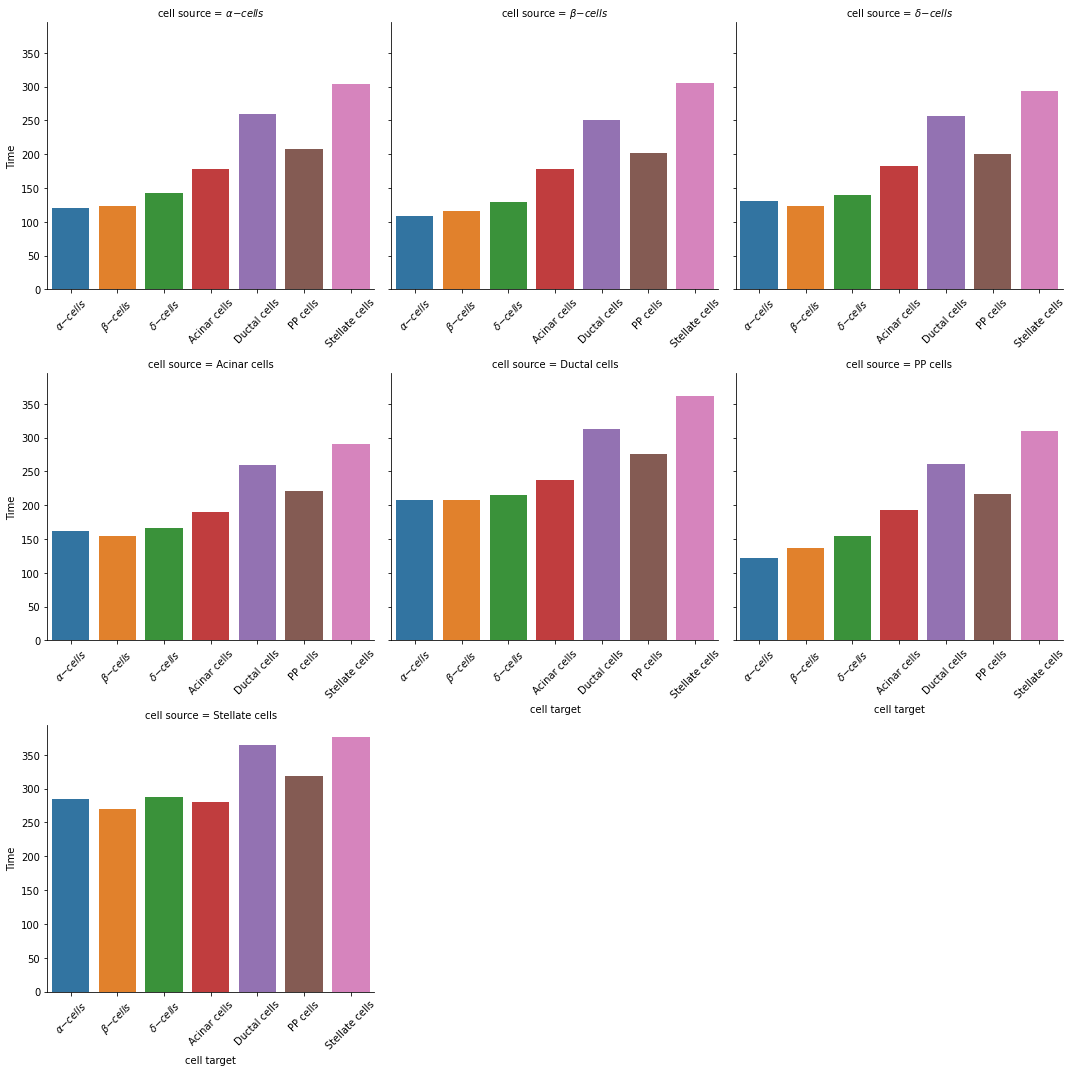

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

paired_table_t2d = df_long_t2d.groupby(["cell source", "cell target"]).size().reset_index(name="Time")
p = sns.catplot(x="cell target", y="Time", data=paired_table_t2d,
            col="cell source",kind="bar",col_wrap=3,sharex=False)
for axes in p.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
plt.tight_layout()

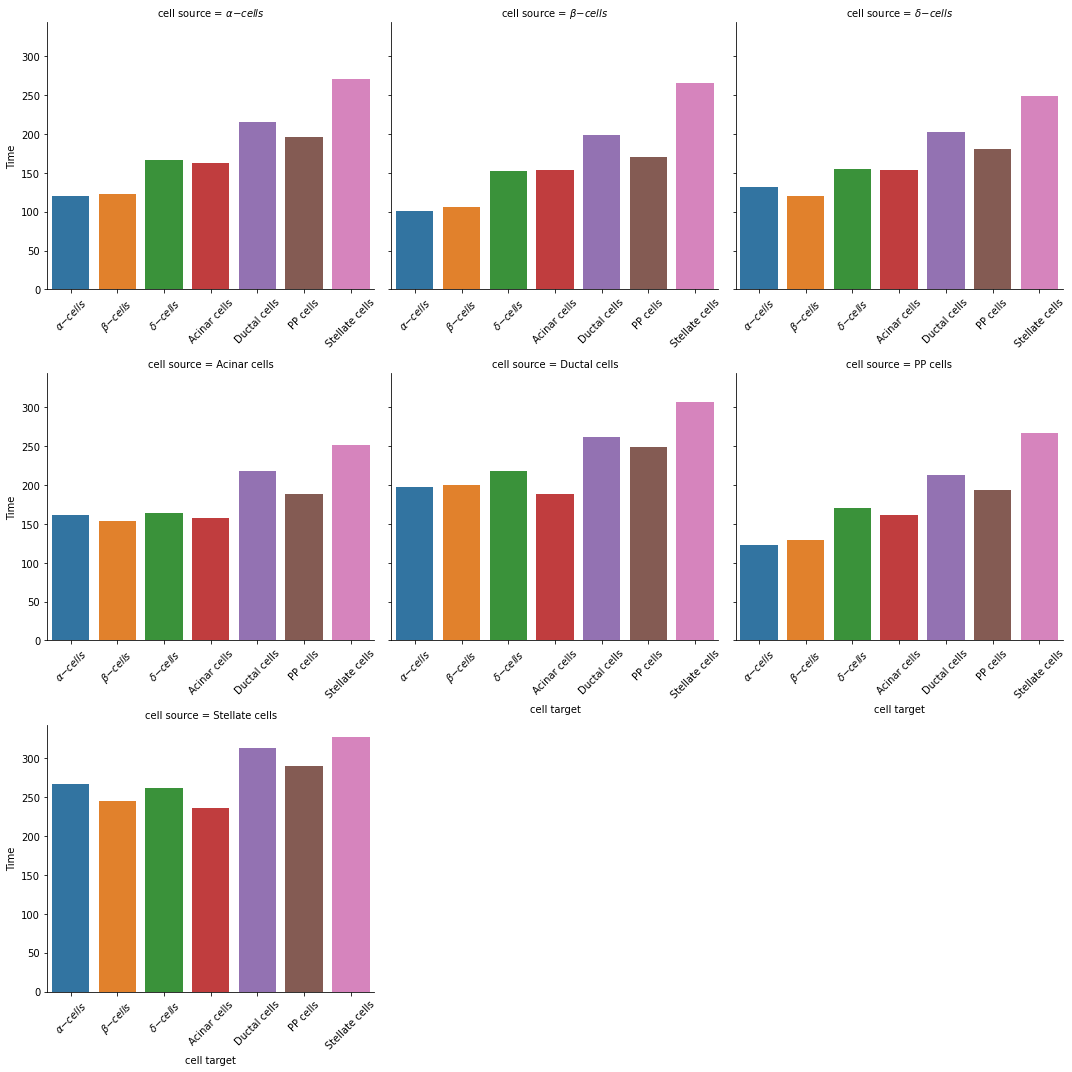

In [9]:
paired_table_nd = df_long_nd.groupby(["cell source", "cell target"]).size().reset_index(name="Time")
p = sns.catplot(x="cell target", y="Time", data=paired_table_nd,
            col="cell source",kind="bar",col_wrap=3,sharex=False)
for axes in p.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
plt.tight_layout()

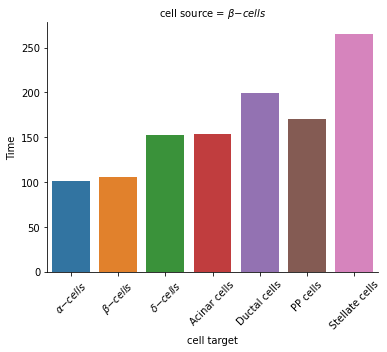

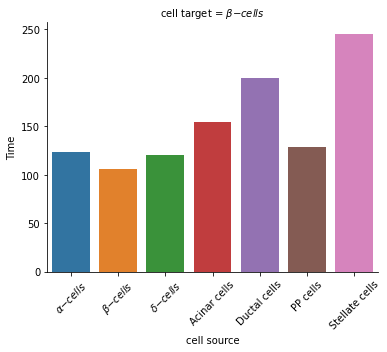

In [10]:
p = sns.catplot(x="cell target", y="Time",
                data=paired_table_nd[paired_table_nd["cell source"] == "$\\beta{-}cells$"],
            col="cell source",kind="bar",col_wrap=3,sharex=False)
for axes in p.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.savefig("interactome_res/figures/figure_6A.pdf")

p = sns.catplot(x="cell source", y="Time",
                data=paired_table_nd[paired_table_nd["cell target"] == "$\\beta{-}cells$"],
            col="cell target",kind="bar",col_wrap=3,sharex=False)
for axes in p.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.savefig("interactome_res/figures/figure_6B.pdf")

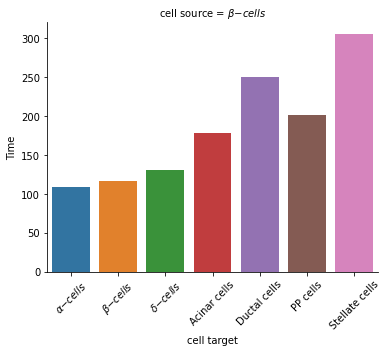

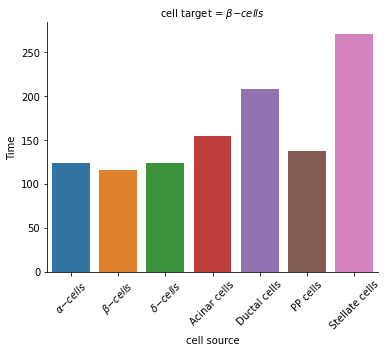

In [11]:
p = sns.catplot(x="cell target", y="Time",
                data=paired_table_t2d[paired_table_t2d["cell source"] == "$\\beta{-}cells$"],
            col="cell source",kind="bar",col_wrap=3,sharex=False)
for axes in p.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.savefig("interactome_res/figures/figure_6C.pdf")

p = sns.catplot(x="cell source", y="Time",
                data=paired_table_t2d[paired_table_t2d["cell target"] == "$\\beta{-}cells$"],
            col="cell target",kind="bar",col_wrap=3,sharex=False)
for axes in p.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.savefig("interactome_res/figures/figure_6D.pdf")

### Comparing the interactions of different cell types

While the barplots provide a nice informative view of the connection variation within a given cell source/target, it's hard to appreciate how different cell types are in terms of difference/similarities of connection profiles. Such information can be glimpsed by looking at the heatmaps obtained for ND and T2D interactomes

#### ND
The first heatmap reports the number of interactions occurring for each pairwise combination of cell targets (rows) and sources (columns)

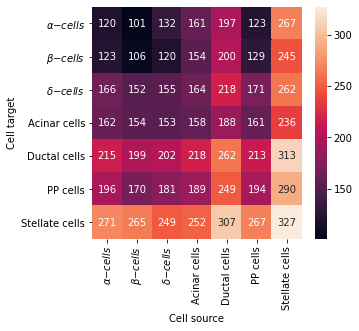

In [12]:
d = {}

# table of interaction counts

interaction_counts_pairs = df_long_nd.groupby(["cell source", "cell target"]).size().reset_index(name="Time")

# square matrix of interactions

for i,s in interaction_counts_pairs.iterrows():
    k1,k2,v = s.values
    d[k1] = d.get(k1,{})
    d[k1][k2] = d[k1].get(k2,0) + (v)
fig, ax = plt.subplots(figsize=(4.7, 4.27))
sns.heatmap(pd.DataFrame(d),annot=True,ax=ax,fmt="d")
ax.set_xlabel("Cell source")
ax.set_ylabel("Cell target")
plt.savefig("interactome_res/figures/figure_1A.pdf")

In [13]:
interaction_counts_pairs.to_csv("interactome_res/tables/Supplementary Table 2.1.csv")

Secondly, two correlation matrices were computed to define the similarities of the interaction patterns of different cell types, considering either as-source and as-target interaction profiles

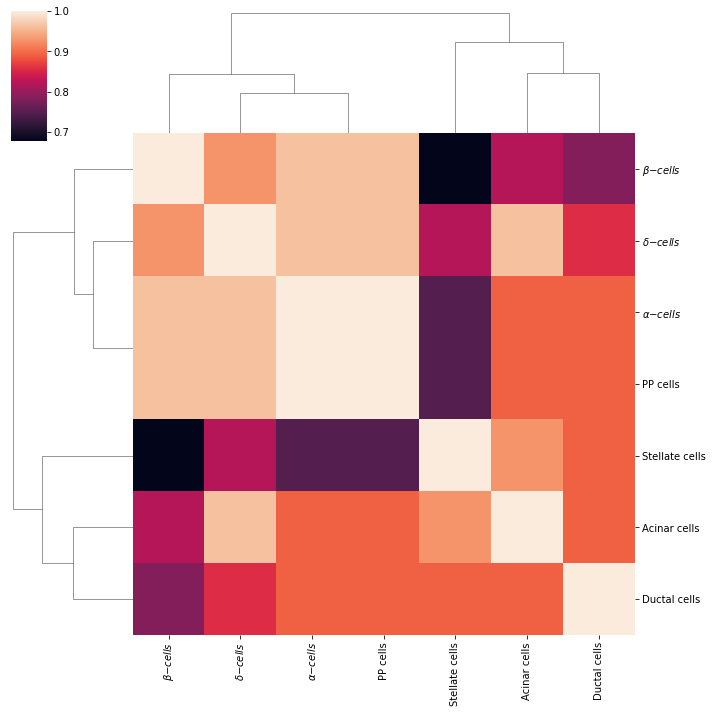

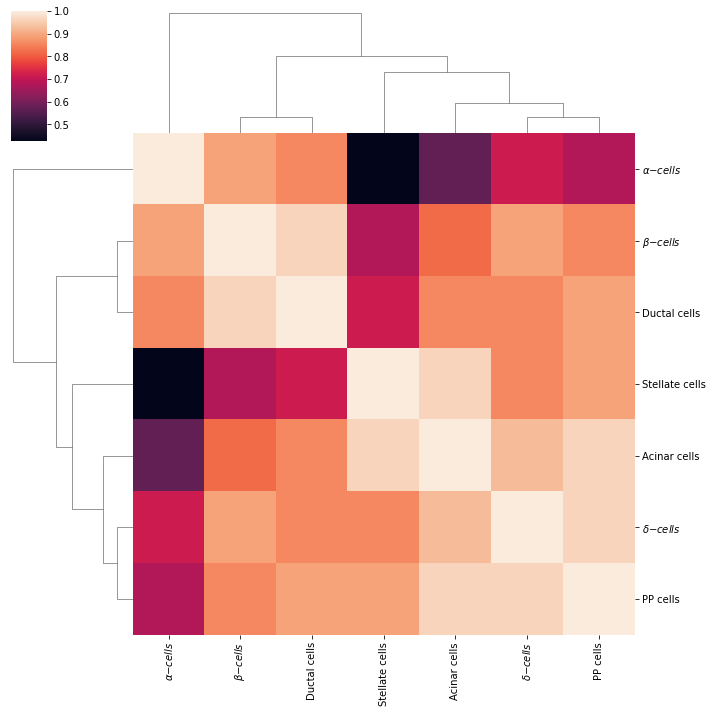

In [14]:
sns.clustermap(pd.DataFrame(d).corr("spearman"))
plt.savefig("interactome_res/figures/figure_1B.pdf")
sns.clustermap(pd.DataFrame(d).T.corr("spearman"))
plt.savefig("interactome_res/figures/figure_1C.pdf")


#### T2D
The same figures as above, but for the T2D interactome

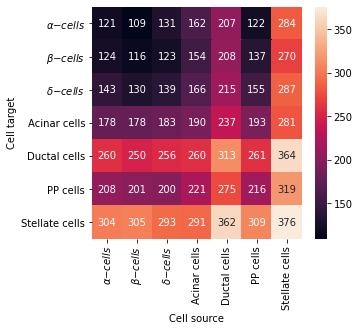

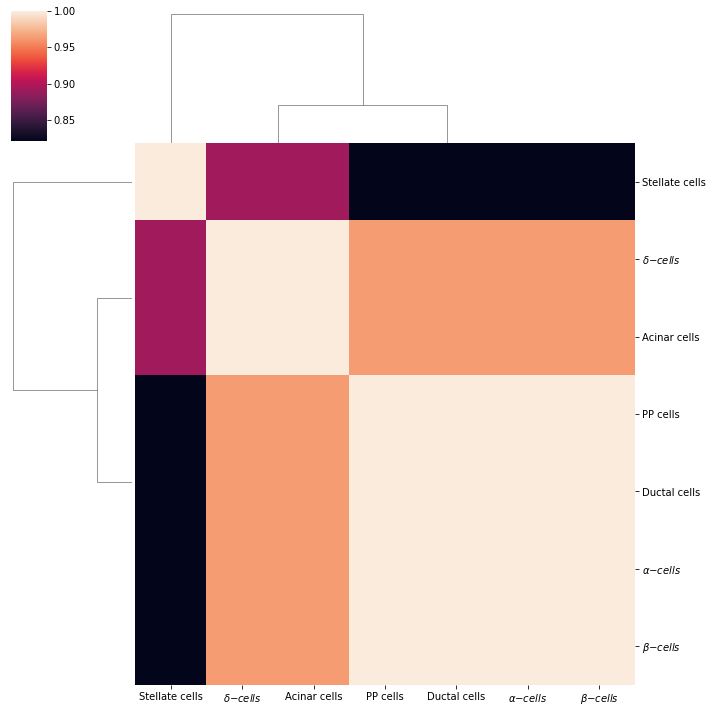

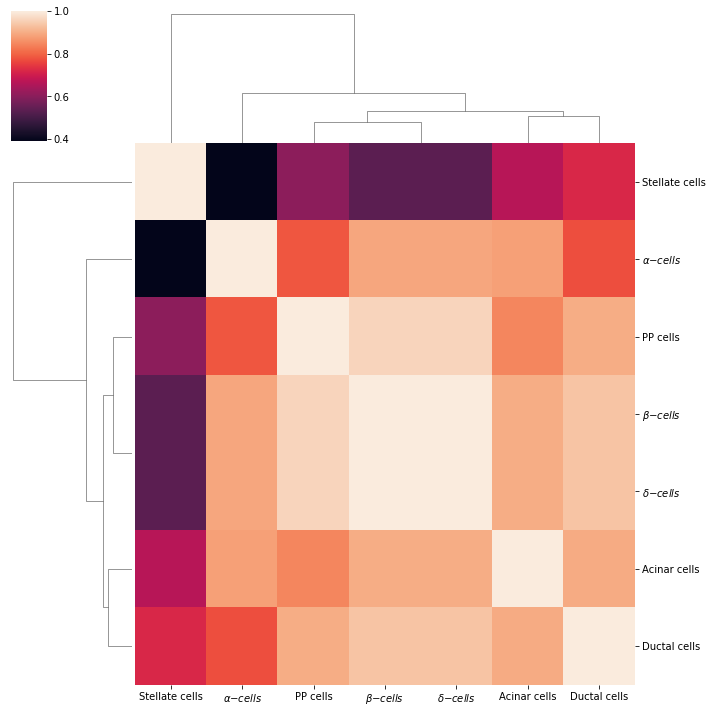

In [15]:
paired_table_t2d = df_long_t2d.groupby(["cell source", "cell target"]).size().reset_index(name="Time")
#p = sns.catplot(x="cell target", y="Time", data=paired_table_t2d,
#            col="cell source",kind="bar",col_wrap=3,sharex=False)
#for axes in p.axes.flat:
#    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
#plt.tight_layout()

d_t2d = {}

# table of interaction counts

interaction_counts_pairs = df_long_t2d.groupby(["cell source", "cell target"]).size().reset_index(name="Time")

# square matrix of interactions

for i,s in interaction_counts_pairs.iterrows():
    k1,k2,v = s.values
    d_t2d[k1] = d_t2d.get(k1,{})
    d_t2d[k1][k2] = d_t2d[k1].get(k2,0) + (v)
fig, ax = plt.subplots(figsize=(4.7, 4.27))
sns.heatmap(pd.DataFrame(d_t2d),annot=True,ax=ax,fmt="d")
ax.set_xlabel("Cell source")
ax.set_ylabel("Cell target")
plt.savefig("interactome_res/figures/figure_4A.pdf")


sns.clustermap(pd.DataFrame(d_t2d).corr("spearman"))
sns.clustermap(pd.DataFrame(d_t2d).T.corr("spearman"))


### Deriving the interaction profile of each cell type, and their comparison
The analysis performed above quantifies the similarity of cell types in terms of the number of connections. However, two cell types may exhibit a similar number of connections, but these can involve different interactions. To capture such information, a more fine-grained analysis is conducted below, measuring the similarity between cell types in terms of presence/absence of the  specific interactions (**interaction profiles**). 
To do this, the `cell target` column was merged with the `interaction` column to define a `specific interaction` column. An example of the result of such operation is "CPI-SS00EC753E6$\\alpha{-}cells$": each row with this entry in the specific interaction column would represent an interaction CPI-SS00EC753E6 specifically interacting alpha cells. Then, a presence/absence matrix is built with 7 columns (one for each as-source cell type) and a row for each specific interaction. Following the example previously reported, the row corresponding to "CPI-SS00EC753E6$\\alpha{-}cells$" would be

| Cell type | CPI-SS00EC753E6 interactions with $\\alpha{-}cells$ |
| --- | --- |
|Ductal cells|0|
|$\beta{-}cells$|0|
|$\alpha{-}cells$|1|
|$\delta{-}cells$|0|
|Stellate cells|0|
|Acinar cells|0|
|PP cells|0|

Meaning that this interaction is only observed between alpha cells (as-source) and alpha cells (as-target).
The whole matrix can be used to compute Jaccard similarities between the columns, effectively indicating how similar are the as-source interactomes of two cell types. A correlation matrix of such similarities is reported as a heatmap.

The same analysis is also performed for the as-target interactomes: the specific interaction is derived by merging the `cell source` column (instead of the `cell target`) was merged with the `interaction` column, whereas the columns in the presence/absence matrix encode the as-target cell types (instead of the as-source cell types).

#### ND

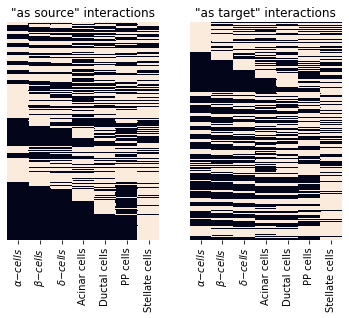

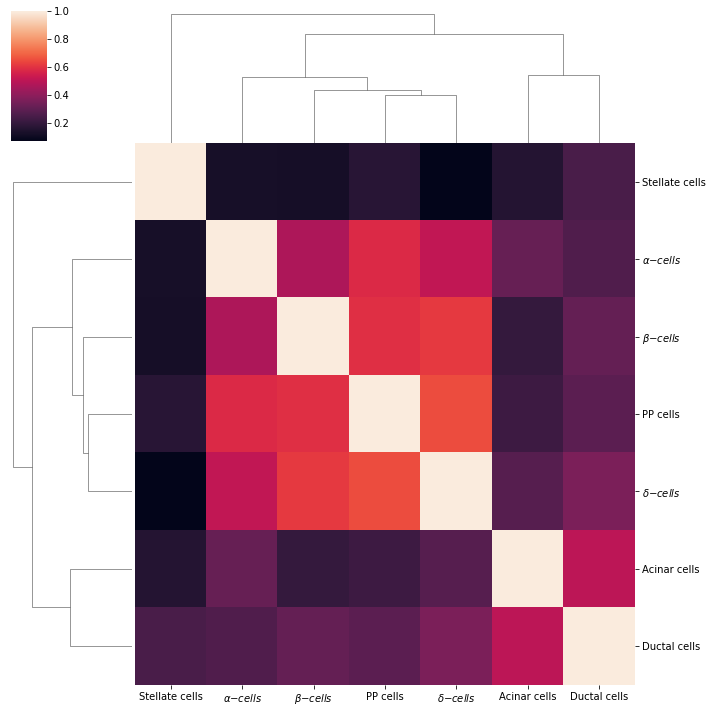

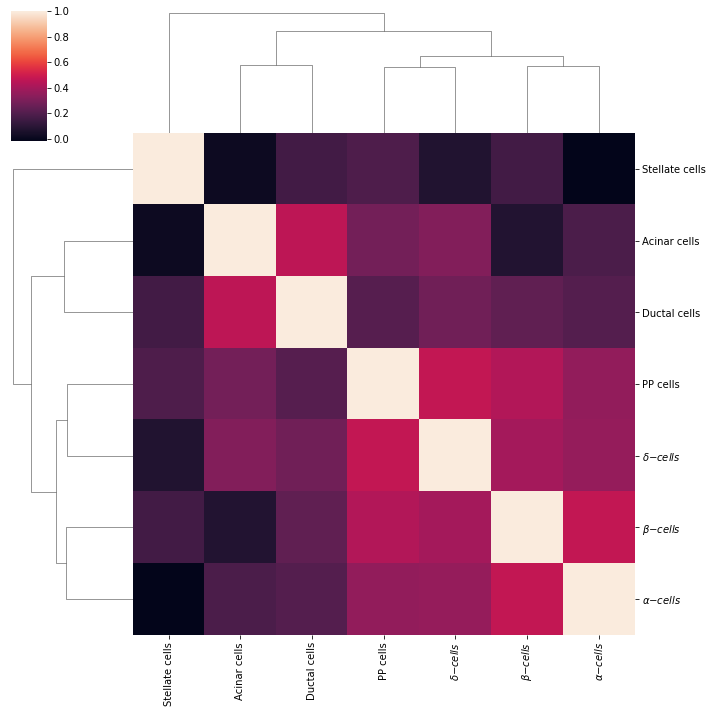

In [16]:
from sklearn.metrics.pairwise import pairwise_distances
import scipy.spatial as sp, scipy.cluster.hierarchy as hc


columns = {i for i in sorted(df_long_nd["cell source"].value_counts().index)}
rows2source = {i:{j:0 for j in columns} for i in df_long_nd.id_cp_interaction + df_long_nd["cell source"]}
rows2target = {i:{j:0 for j in columns} for i in df_long_nd.id_cp_interaction + df_long_nd["cell target"]}

for i,v in (df_long_nd.id_cp_interaction + df_long_nd["cell source"]).iteritems():
    target = df_long_nd.loc[i,"cell target"]
    rows2source[v][target] = 1

for i,v in (df_long_nd.id_cp_interaction + df_long_nd["cell target"]).iteritems():
    source = df_long_nd.loc[i,"cell source"]
    rows2target[v][source] = 1

#sns.clustermap(pd.DataFrame(rows2source).T.corr("spearman"))
#sns.heatmap(pd.DataFrame(rows2source).T)
#sns.heatmap(pd.DataFrame(rows2target).T)
column_order = ['$\\alpha{-}cells$','$\\beta{-}cells$','$\\delta{-}cells$','Acinar cells','Ductal cells','PP cells', 'Stellate cells']
f,axes = plt.subplots(1,2)
axes[0].title.set_text('"as source" interactions')
axes[1].title.set_text('"as target" interactions')
sns.heatmap(pd.DataFrame(rows2target).T[column_order],ax = axes[0],yticklabels=False,cbar=False)
sns.heatmap(pd.DataFrame(rows2source).T[column_order],ax = axes[1],yticklabels=False,cbar=False)
plt.savefig("interactome_res/figures/figure_1D.pdf")
#g = sns.clustermap(iris, row_colors=row_colors, figsize=(13,8))

#sns.clustermap(distance_m, row_linkage=linkage, col_linkage=linkage)
#sns.heatmap(pd.DataFrame(rows2source).T)
sns.clustermap(pd.DataFrame(rows2target).T.corr("spearman"))
plt.savefig("interactome_res/figures/figure_1E.pdf")
sns.clustermap(pd.DataFrame(rows2source).T.corr("spearman"))
plt.savefig("interactome_res/figures/figure_1F.pdf")

#### T2D

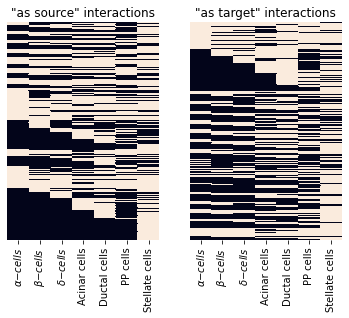

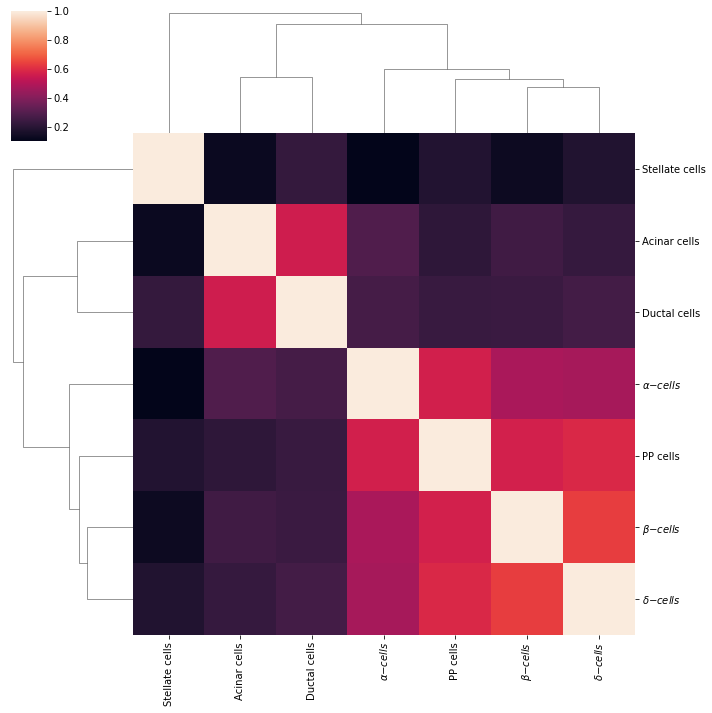

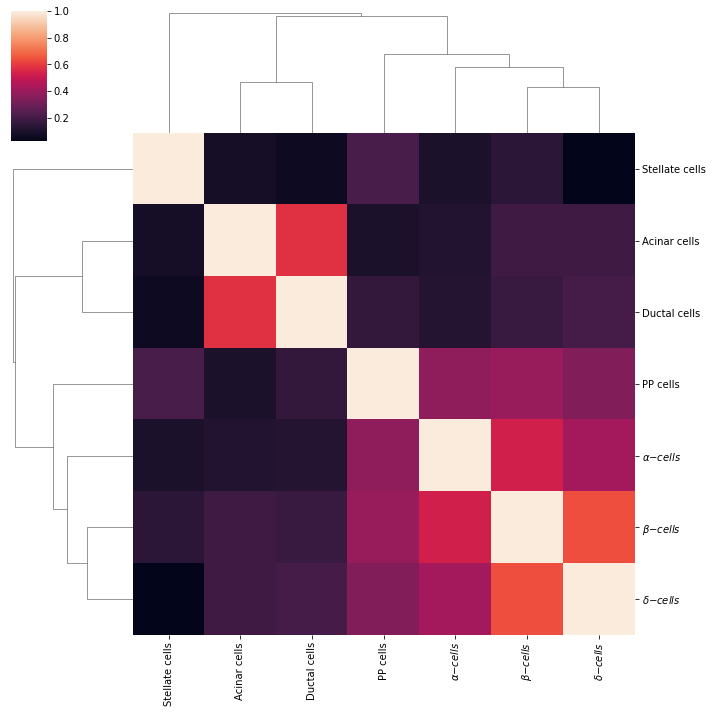

In [17]:
from sklearn.metrics.pairwise import pairwise_distances
import scipy.spatial as sp, scipy.cluster.hierarchy as hc


columns = {i for i in sorted(df_long_t2d["cell source"].value_counts().index)}
rows2source = {i:{j:0 for j in columns} for i in df_long_t2d.id_cp_interaction + df_long_t2d["cell source"]}
rows2target = {i:{j:0 for j in columns} for i in df_long_t2d.id_cp_interaction + df_long_t2d["cell target"]}

for i,v in (df_long_t2d.id_cp_interaction + df_long_t2d["cell source"]).iteritems():
    target = df_long_t2d.loc[i,"cell target"]
    rows2source[v][target] = 1

for i,v in (df_long_t2d.id_cp_interaction + df_long_t2d["cell target"]).iteritems():
    source = df_long_t2d.loc[i,"cell source"]
    rows2target[v][source] = 1

#sns.clustermap(pd.DataFrame(rows2source).T.corr("spearman"))
#sns.heatmap(pd.DataFrame(rows2source).T)
#sns.heatmap(pd.DataFrame(rows2target).T)
column_order = ['$\\alpha{-}cells$','$\\beta{-}cells$','$\\delta{-}cells$','Acinar cells','Ductal cells','PP cells', 'Stellate cells']
f,axes = plt.subplots(1,2)
axes[0].title.set_text('"as source" interactions')
axes[1].title.set_text('"as target" interactions')
sns.heatmap(pd.DataFrame(rows2target).T[column_order],ax = axes[0],yticklabels=False,cbar=False)
sns.heatmap(pd.DataFrame(rows2source).T[column_order],ax = axes[1],yticklabels=False,cbar=False)
plt.savefig("interactome_res/figures/figure_4B.pdf")
#g = sns.clustermap(iris, row_colors=row_colors, figsize=(13,8))

#sns.clustermap(distance_m, row_linkage=linkage, col_linkage=linkage)
#sns.heatmap(pd.DataFrame(rows2source).T)
sns.clustermap(pd.DataFrame(rows2target).T.corr("spearman"))
plt.savefig("interactome_res/figures/figure_4C.pdf")
sns.clustermap(pd.DataFrame(rows2source).T.corr("spearman"))
plt.savefig("interactome_res/figures/figure_4D.pdf")

The tables are exported to be reported in Supplementary Table 2

In [18]:
pd.DataFrame(rows2target).T[column_order].to_csv("interactome_res/tables/Supplementary Table 2.2.csv")
pd.DataFrame(rows2source).T[column_order].to_csv("interactome_res/tables/Supplementary Table 2.3.csv")

## 3) Contrasting the T2D and ND interactomes
After defining and characterizing the interactomes of T2D and ND cells, one crucial aspect to investigate is how much different the two are, and which interactions drive such differences, i.e. which interactions are specifically present only in T2D or ND. This analysis is detailed below

First, similarly as done before, the matrices interaction profiles for T2D and ND interactomes are produced (as-source and as-target, respectively). Then, these are clustered by computing the Jaccard similarities between the profiles and reported as clustermaps.

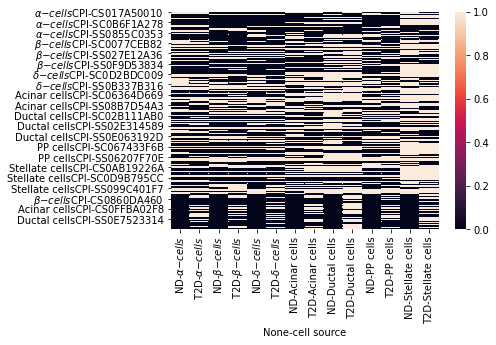

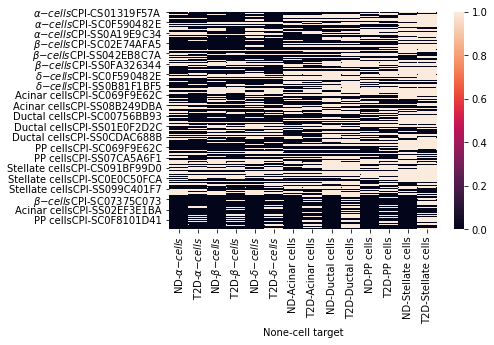

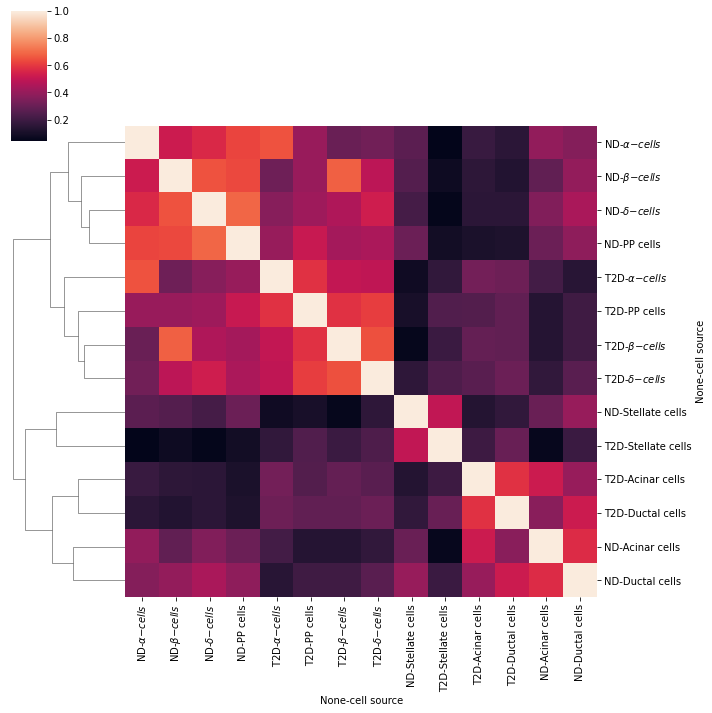

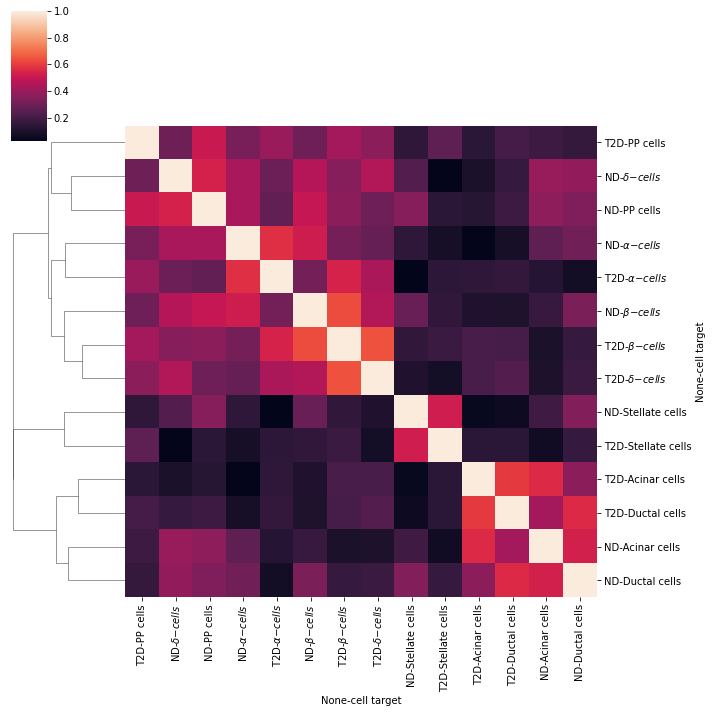

In [19]:
### 1) get the reduced df and do counts
## as_source
# T2D
pivoted_s = pd.DataFrame({"cell source":df_long_t2d["cell source"],
                        "interaction":(df_long_t2d["cell target"]+df_long_t2d["id_cp_interaction"]),
                        "T2D":1})
pivoted_s_t2d = pivoted_s.groupby(['interaction', 'cell source']).count().unstack().fillna(0)
# ND
pivoted_s = pd.DataFrame({"cell source":df_long_nd["cell source"],
                        "interaction":(df_long_nd["cell target"]+df_long_nd["id_cp_interaction"]),
                        "ND":1})
pivoted_s_nd = pivoted_s.groupby(['interaction', 'cell source']).count().unstack().fillna(0)

# merge ND and T2D
pivoted_s_merged = pd.concat([pivoted_s_nd,pivoted_s_t2d],axis=1).fillna(0)

## as_target
# T2D
pivoted_t = pd.DataFrame({"cell target":df_long_t2d["cell target"],
                        "interaction":(df_long_t2d["cell source"]+df_long_t2d["id_cp_interaction"]),
                        "T2D":1})
pivoted_t_t2d = pivoted_t.groupby(['interaction', 'cell target']).count().unstack().fillna(0)
# ND
pivoted_t = pd.DataFrame({"cell target":df_long_nd["cell target"],
                        "interaction":(df_long_nd["cell source"]+df_long_nd["id_cp_interaction"]),
                        "ND":1})
pivoted_t_nd = pivoted_t.groupby(['interaction', 'cell target']).count().unstack().fillna(0)

# merge ND and T2D
pivoted_t_merged = pd.concat([pivoted_t_nd,pivoted_t_t2d],axis=1).fillna(0)


### 2) plot pres/abs matrix
sns.heatmap(pivoted_s_merged.loc[:,[(i,j) for j in column_order for i in ["ND","T2D"]]])
plt.savefig("interactome_res/figures/figure_5A.pdf")
plt.show()
sns.heatmap(pivoted_t_merged.loc[:,[(i,j) for j in column_order for i in ["ND","T2D"]]])
plt.savefig("interactome_res/figures/figure_5B.pdf")
plt.show()

### 3) plot clustermap of cell types
cl1 = sns.clustermap(pivoted_s_merged.corr("spearman"))
cl1.ax_col_dendrogram.set_visible(False)
plt.savefig("interactome_res/figures/figure_5C.pdf")
cl2 = sns.clustermap(pivoted_t_merged.corr("spearman"))
cl2.ax_col_dendrogram.set_visible(False)
plt.savefig("interactome_res/figures/figure_5D.pdf")

In [20]:
pivoted_s_t2d.to_excel("interactome_res/tables/Supplementary Table 8.xlsx")
pivoted_t_t2d.to_excel("interactome_res/tables/Supplementary Table 8B.xlsx")

Then, a contrast is obtained by comparing the two interaction profiles (T2D and ND) of each cell type. Each interaction is classified in 4 categories, that are:
- Absent: when an interaction is absent both in T2D and ND (both profiles have a '0' for that reaction)
- Stable: when an interaction is present both in T2D and ND (both profiles have a '1' for that reaction)
- Gained: when an interaction is present in T2D but absent in ND (the T2D and ND profiles have a '1' and '0', respectively, for that reaction)
- Lost: when an interaction is absent in T2D but present in ND (the T2D and ND profiles have a '0' and '1', respectively, for that reaction)

The results of the classification obtained for the two contrasts (as-source T2D vs as-source ND; as-target T2D vs as-target ND)

In [21]:
import numpy as np

def classifyInteraction(nd,t2d):
    if nd==t2d==0: return "Absent"
    if nd==t2d==1: return "Stable"
    if nd==0 and t2d==1: return "Gained"
    if nd==1 and t2d==0: return "Lost"

classifyInteractionV = np.vectorize(classifyInteraction)

def classifyAllInteractions(nd,t2d):
    rowNames = nd.index.values
    all_interactions = classifyInteractionV(nd,t2d)
    colNames = nd.columns.values
    contrasted = pd.DataFrame.from_dict({t[0]:list(t[1]) for t in zip(rowNames,all_interactions)},
                                        orient="index",columns=colNames)
    return contrasted

How the contrasted dataframe looks like:

In [22]:
classifyAllInteractions(pivoted_s_merged["ND"],pivoted_s_merged["T2D"])

,$\alpha{-}cells$,$\beta{-}cells$,$\delta{-}cells$,Acinar cells,Ductal cells,PP cells,Stellate cells
$\alpha{-}cells$CPI-CS017A50010,Gained,Absent,Absent,Absent,Absent,Gained,Stable
$\alpha{-}cells$CPI-CS01A4D7E2F,Absent,Stable,Stable,Absent,Absent,Stable,Absent
$\alpha{-}cells$CPI-CS0247DA882,Lost,Lost,Lost,Lost,Lost,Lost,Stable
$\alpha{-}cells$CPI-CS0288D901D,Absent,Gained,Gained,Absent,Absent,Gained,Stable
$\alpha{-}cells$CPI-CS028ACED72,Absent,Absent,Lost,Stable,Stable,Absent,Gained
...,...,...,...,...,...,...,...
Stellate cellsCPI-SS0E075E5AF,Absent,Absent,Absent,Absent,Absent,Gained,Absent
Stellate cellsCPI-SS0E91E504D,Gained,Gained,Gained,Absent,Gained,Gained,Gained
Stellate cellsCPI-SS0ED2573CA,Absent,Absent,Absent,Gained,Gained,Absent,Absent
Stellate cellsCPI-SS0EDD4928A,Gained,Gained,Gained,Absent,Gained,Gained,Gained


plot as a clustermap the contrasted interactomes (respectively as-source and as-target)

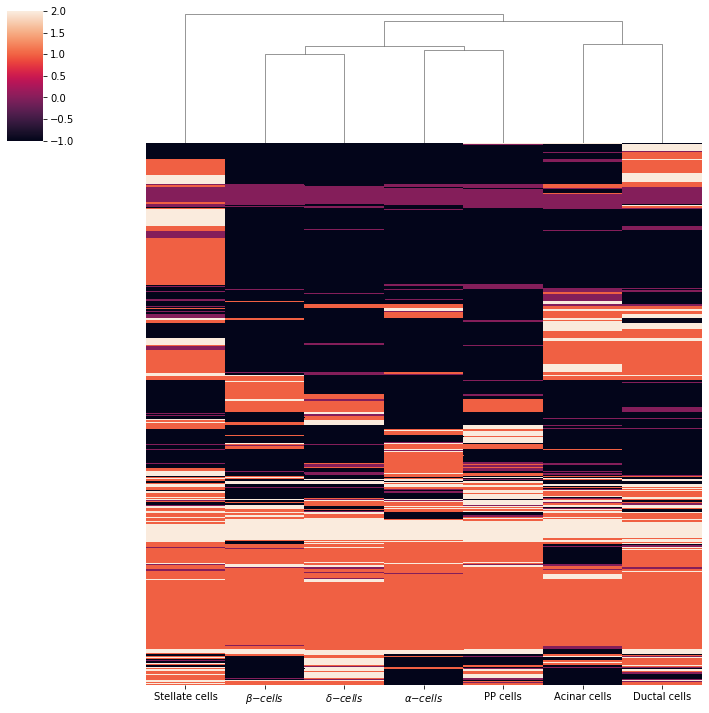

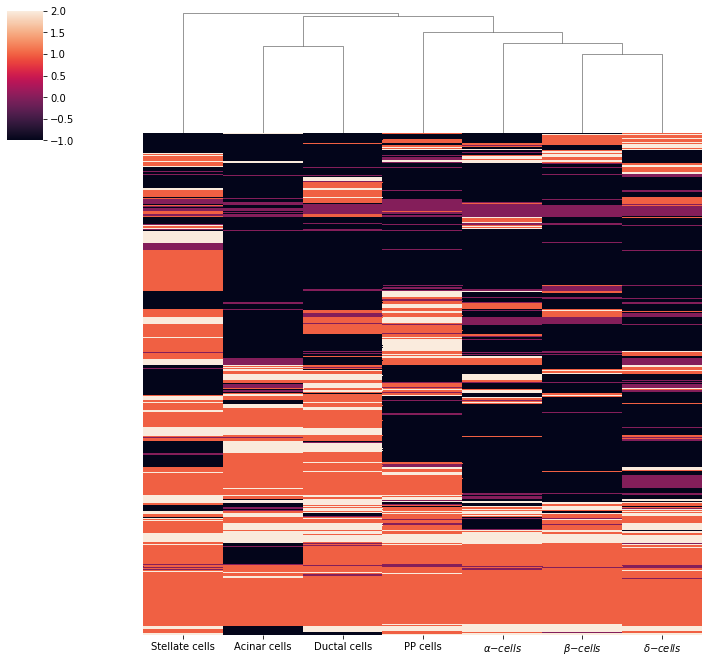

In [23]:
# plot clustermap of gained/stable/lost interactions
# pivoted_contrast_s = pivoted_s_merged["T2D"] - pivoted_s_merged["ND"]
pivoted_contrast_s = classifyAllInteractions(pivoted_s_merged["ND"],pivoted_s_merged["T2D"])
pivoted_contrast_t = classifyAllInteractions(pivoted_t_merged["ND"],pivoted_t_merged["T2D"])
#pivoted_contrast_s = pivoted_contrast_s.apply(lambda x: x.map({1:"Gained",0:"Stable",-1:"Lost"}))
#pivoted_contrast_t = pivoted_t_merged["T2D"] - pivoted_t_merged["ND"]
cm1 = sns.clustermap(pivoted_contrast_s.apply(
    lambda x: x.map({"Gained":2,"Stable":1,"Lost":0,"Absent":-1})),yticklabels=False)
cm1.ax_row_dendrogram.set_visible(False)
plt.setp(cm1.ax_heatmap.xaxis.get_majorticklabels(), rotation=0)
plt.savefig("interactome_res/figures/figure_5E.pdf")
#cm1.cax.set_visible(False)
cm2 = sns.clustermap(pivoted_contrast_t.apply(
    lambda x: x.map({"Gained":2,"Stable":1,"Lost":0,"Absent":-1})),yticklabels=False)
cm2.ax_row_dendrogram.set_visible(False)
plt.setp(cm2.ax_heatmap.xaxis.get_majorticklabels(), rotation=0)
plt.savefig("interactome_res/figures/figure_5F.pdf")
#cm2 = sns.clustermap(pivoted_contrast_t,yticklabels=False)
#cm2.cax.set_visible(False)

In [24]:
pivoted_contrast_s.to_excel("interactome_res/tables/Supplementary Table 9.xlsx")
pivoted_contrast_t.to_excel("interactome_res/tables/Supplementary Table 9B.xlsx")

## 4) Network analysis of ND and T2D interactomes
In this section, the two interactomes will be analysed with algorithms from network theory to assess the importance of genes and interaction for the whole islet system. Networks will be generated from the interaction tables produced in the previous sections  

In [25]:
import networkx as nx

##### Building the genes + cell types (G+C) network
`g2_nd` and `g2_t2d` encode the networks of cell types and genes: a graph with nodes for cell types and genes, and edges connect genes that interact each other (sources and target), as well connecting to cell types that express them.

Nodes have attributes indicating the type of node, gene-gene edges contain the *rank* attribute that indicate the interaction specificity and cell-gene edges have a weight indicating the number of interactions.

In [26]:
g2_nd,g2_t2d = nx.DiGraph(),nx.DiGraph()

In [27]:
def addEdgeData(df,g):
    def addEdgeUpdatingWeight(n1,n2,g,weight=1,**kwargs):
        w = g.get_edge_data(n1,n2,{}).get("weight",0) + weight
        g.add_edge(n1,n2,weight=w)
        return
    
    for row in df[(-df["gene_a"].isnull() & -df["gene_b"].isnull())].\
    loc[:,["gene_a","gene_b","cell source","cell target","receptor_a","receptor_b","rank","value"]].values:
        gene1,gene2,cell1,cell2,receptor_a,receptor_b,rank,score = row
        if(receptor_a == True) and (receptor_b == False):
            # C2 -> G2 -> G1 -> C1
            addEdgeUpdatingWeight(cell2,gene2,g)
            addEdgeUpdatingWeight(gene2,gene1,g)            
            addEdgeUpdatingWeight(gene1,cell1,g)
        if(receptor_a == False) and (receptor_b == True):
            # C1 -> G1 -> G2 -> C2
            addEdgeUpdatingWeight(cell1,gene1,g)
            addEdgeUpdatingWeight(gene1,gene2,g)
            addEdgeUpdatingWeight(gene2,cell2,g)
        else:
            # C2 -> G2 -> G1 -> C1
            addEdgeUpdatingWeight(cell2,gene2,g)
            addEdgeUpdatingWeight(gene2,gene1,g)
            addEdgeUpdatingWeight(gene1,cell1,g)
            # C1 -> G1 -> G2 -> C2
            addEdgeUpdatingWeight(cell1,gene1,g)
            addEdgeUpdatingWeight(gene1,gene2,g)
            addEdgeUpdatingWeight(gene2,cell2,g)        

In [28]:
for g,df in zip([g2_nd,g2_t2d],[df_long_nd,df_long_t2d]):
    addEdgeData(df,g)

export the networks as gexf for reproducibility (is actually commented since I already done that)

In [29]:
# export networks as gexf
baseDir = "interactome_res/networks/"
for g,name_ in zip([g2_nd,g2_t2d],\
                  ["genes_ND.gexf","genes_T2D.gexf"]):
    nx.write_gexf(g,"%s%s" %(baseDir,name_))

recreate the networks by reading the gexf files previously written (again, this step is for reproducibility, it can be skipped if the previous commands were executed)

In [30]:
g2_nd = nx.read_gexf(baseDir + "genes_ND.gexf")
g2_t2d = nx.read_gexf(baseDir + "genes_T2D.gexf")

##### Compute centrality measures for the G+C network
Considering only the ND interactions, centrality measures for genes in the G+C network are computed. Note that:
- all these measures will be reported for gene nodes only
- some algorithms use weight as distance measure, i.e. high values imply greater differences. For these, a distance measure will be derived by computing the inverse of the weight associated to the edge (`distance = 1.0 / weight`) 

In [31]:
for e in g2_nd.edges:
    n1,n2 = e
    g2_nd[n1][n2]["distance"] = 1./g2_nd[n1][n2]["weight"]

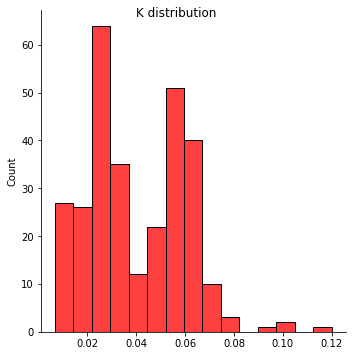

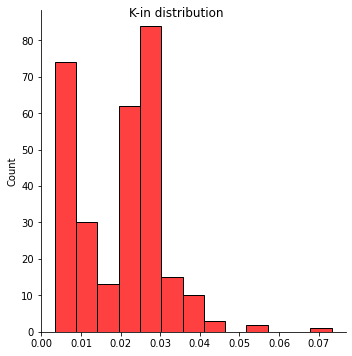

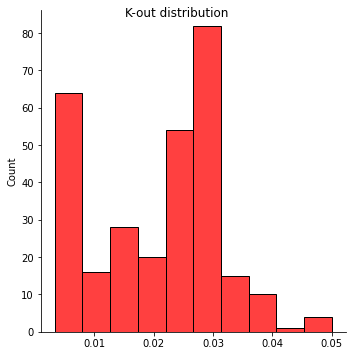

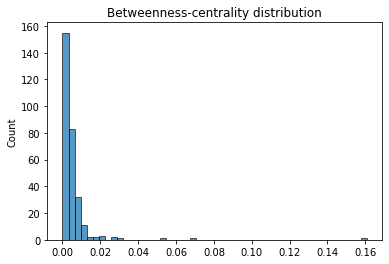

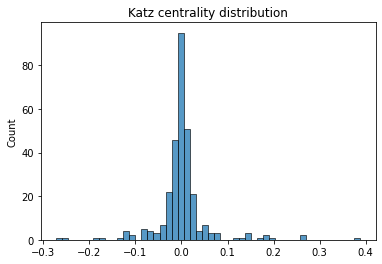

In [32]:
## degree centrality
# get K only for genes
K_dist = {k:v for k,v in nx.degree_centrality(g2_nd).items() if k.startswith("ENS")}
f = sns.displot(K_dist,color="red")
f.fig.suptitle("K distribution")
plt.savefig("interactome_res/figures/figure_2A.pdf")
plt.show()

# get K-in only for genes
K_in_dist = {k:v for k,v in nx.in_degree_centrality(g2_nd).items() if k.startswith("ENS")}
f = sns.displot(K_in_dist,color="red")
f.fig.suptitle("K-in distribution")
plt.savefig("interactome_res/figures/figure_2B.pdf")
plt.show()

# get K only for genes
K_out_dist = {k:v for k,v in nx.out_degree_centrality(g2_nd).items() if k.startswith("ENS")}
f = sns.displot(K_out_dist,color="red")
f.fig.suptitle("K-out distribution")
plt.savefig("interactome_res/figures/figure_2C.pdf")
plt.show()


## betweenness-centrality (B)
# get only genes values
B_dist = {k:v for k,v in nx.betweenness_centrality(g2_nd,weight="distance").items() if k.startswith("ENS")}
f = sns.histplot(B_dist,bins=50)
f.title.set_text("Betweenness-centrality distribution")
plt.savefig("interactome_res/figures/figure_2D.pdf")
plt.show()
#sorted(K_dist.items(),key=lambda x: x[1])

## katz centrality (cfB)
# get only genes values
katz_dist = {k:v for k,v in nx.katz_centrality_numpy(g2_nd,weight="weight").items() if k.startswith("ENS")}
f = sns.histplot(katz_dist,bins=50)
f.title.set_text("Katz centrality distribution")
plt.show()
#sorted(K_dist.items(),key=lambda x: x[1])





#g2_nd.nodes[list(g2_nd.nodes())[0]]

Actually the computation of katz centrality requires the definition of an attenuation parameter. As indicated elsewhere, attenuation should be set as the inverse of the maximum of the spectral value for the adjacency matrix. Below the correct katz centrality distribution.

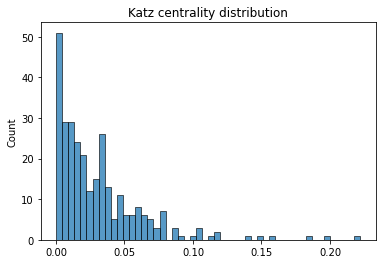

In [33]:
attenuation = 1/max(nx.adjacency_spectrum(g2_nd))
katz_dist = {k:v for k,v in nx.katz_centrality_numpy(g2_nd,attenuation.real,weight="weight").items() if k.startswith("ENS")}
f = sns.histplot(katz_dist,bins=50)
f.title.set_text("Katz centrality distribution")
plt.savefig("interactome_res/figures/figure_2E.pdf")
plt.show()

In [34]:
from scipy import stats
stats.shapiro([v for i,v in katz_dist.items()])

(0.7781565189361572, 1.129098304960615e-19)

In [35]:
ens2name = {}
for l in open("interactome_src/id2gene_name.uniq.tsv"):
    k,v = l.strip().split()
    ens2name[k] = v

In [36]:
K_distr_df = pd.DataFrame.from_dict(K_dist,orient="index",columns=["K"])
K_distr_df["K-in"] = pd.DataFrame.from_dict(K_in_dist,orient="index")[0]
K_distr_df["K-out"] = pd.DataFrame.from_dict(K_out_dist,orient="index")[0]
K_distr_df["Gene Name"] = K_distr_df.index.map(ens2name)

In [37]:
B_distr_df = pd.DataFrame.from_dict(B_dist,orient="index",columns=["B"]).sort_values("B",ascending=False)
B_distr_df["Gene Name"] = B_distr_df.index.map(ens2name)
Katz_distr_df = pd.DataFrame.from_dict(katz_dist,orient="index",columns=["Katz"])
Katz_distr_df["Absolute Katz"] = Katz_distr_df.Katz.map(abs)
Katz_distr_df["Gene Name"] = Katz_distr_df.index.map(ens2name)
Katz_distr_df = Katz_distr_df.sort_values("Absolute Katz",ascending=False)

export the values of K, B and Katz for Supplementary Tables

In [38]:
K_distr_df.to_excel("interactome_res/tables/Supplementary Table 3.xlsx")
B_distr_df.to_excel("interactome_res/tables/Supplementary Table 4.xlsx")
Katz_distr_df.to_excel("interactome_res/tables/Supplementary Table 5.xlsx")

Using a 95 percentile threshold, genes with extremely high centrality values are identified in each distribution.
Then, the different sets are compared to identify high-centrality genes that consistently for all measures 

In [39]:
K_top = K_distr_df[K_distr_df["K"] >= K_distr_df["K"].quantile(.95)].sort_values("K",ascending=False)
print(K_top.shape)
K_top.to_csv("interactome_res/tables/K_top5.csv")

(17, 4)


In [40]:
Kin_top = K_distr_df[K_distr_df["K-in"] >= K_distr_df["K-in"].quantile(.95)].sort_values("K-in",ascending=False)
print(Kin_top.shape)
Kin_top.to_csv("interactome_res/tables/Kin_top5.csv")

(16, 4)


In [41]:
Kout_top = K_distr_df[K_distr_df["K-out"] >= K_distr_df["K-out"].quantile(.95)].sort_values("K-out",ascending=False)
print(Kout_top.shape)
Kout_top.to_csv("interactome_res/tables/Kout_top5.csv")

(15, 4)


In [42]:
B_top = B_distr_df[B_distr_df["B"] >= B_distr_df["B"].quantile(.95)]
print(B_top.shape)
B_top.to_csv("interactome_res/tables/B_top5.csv")

(15, 2)


In [43]:
Katz_top = Katz_distr_df[Katz_distr_df["Katz"] >= Katz_distr_df["Katz"].quantile(.95)]
print(Katz_top.shape)
Katz_top.to_csv("interactome_res/tables/Katz_top5.csv")

(15, 3)


In [44]:
sets_ = [set(i["Gene Name"].values) for i in [K_top,Kin_top,Kout_top,B_top,Katz_top]]
#set.union(*sets_)

In [45]:
row_names = list(set.union(*sets_))
column_names = ["K","K-in","K-out","BC","KC"]
rows = {}
for r in row_names:
    row = []
    for i,c in enumerate(column_names):
        if r in sets_[i]: row += [1]
        else: row += [0]
    rows[r] = row
extreme_genes_comparison = pd.DataFrame.from_dict(rows,orient="index",columns=column_names)
extreme_genes_comparison.pipe(lambda df: df.loc[df.sum(axis=1).sort_values(ascending=False).index,])
#extreme_genes_comparison.sort_values(axis=1,key=sum,ascending=False)
#sum(1)
#extreme_genes_comparison[.sort_values(ascending=False).index]
#extreme_genes_comparison 

,K,K-in,K-out,BC,KC
FAM3C,1,1,1,1,1
FGFR1,1,1,1,1,1
FGFR2,1,1,1,1,1
PVRL3,1,1,1,1,1
EGFR,1,1,1,1,1
PVRL1,1,1,1,1,0
NRP2,1,1,1,1,0
WNT5A,1,0,1,1,1
NRP1,1,1,1,0,0
TNF,0,0,1,1,1


In [46]:
extreme_genes_df = extreme_genes_comparison.pipe(lambda df: df.loc[df.sum(axis=1).sort_values(ascending=False).index,])
extreme_genes_df.to_excel("interactome_res/tables/Supplementary Table 6.xlsx")

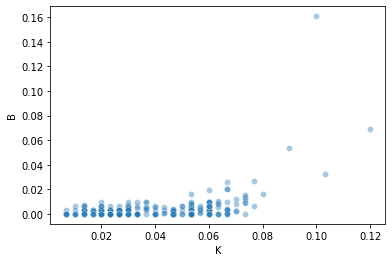

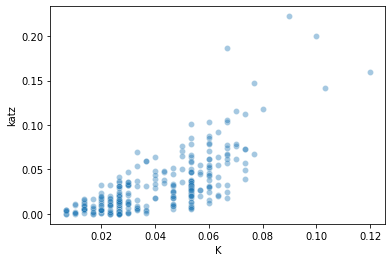

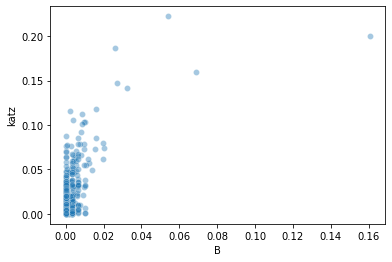

In [47]:
# see how centrality measures covariate
K_B_kz = pd.DataFrame([K_dist,B_dist,katz_dist]).T
K_B_kz.columns = ["K","B","katz"]
f = sns.scatterplot(data=K_B_kz, x="K", y="B",alpha=0.4)
plt.show()
f2 = sns.scatterplot(data=K_B_kz, x="K", y="katz",alpha=0.4)
plt.show()
f2 = sns.scatterplot(data=K_B_kz, x="B", y="katz",alpha=0.4)


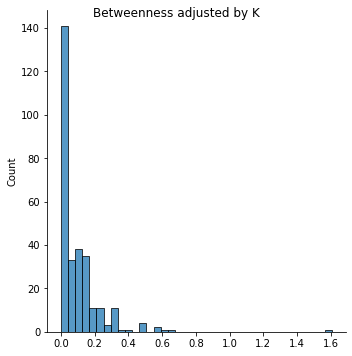

In [48]:
k_adjusted_B = K_B_kz["B"]/K_B_kz["K"]
f = sns.displot(k_adjusted_B)
f.fig.suptitle("Betweenness adjusted by K")
plt.show()
#sorted(K_dist.items(),key=lambda x: x[1])

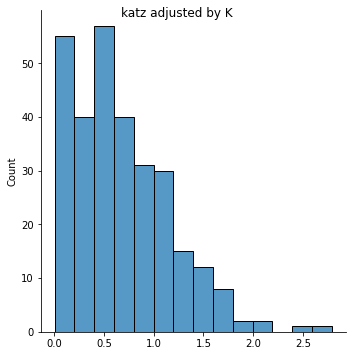

In [49]:
k_adjusted_B = K_B_kz["katz"]/K_B_kz["K"]
f = sns.displot(k_adjusted_B)
f.fig.suptitle("katz adjusted by K")
plt.show()
#sorted(K_dist.items(),key=lambda x: x[1])

#### Network difference
As a last point, a difference graph, embedding the changing connections from ND to T2D (i.e. gained and lost interactions) is produced 

In [50]:
difference_g = nx.Graph()
# add interactions "lost" in T2D
for e in set(g2_nd.edges()).difference(set(g2_t2d.edges())):
    difference_g.add_edge(*e,type="lost")
# add interactions "gained" in T2D
for e in set(g2_t2d.edges()).difference(set(g2_nd.edges())):
    difference_g.add_edge(*e,type="gained")
#difference_g.edges

## 5) The beta cell interactome in ND and T2D

Given the primary role of beta cells in T2D pathophysiology, the complex interaction patterns reported above where reduced to investigate the set of interactions involving beta cells, either as-source or as-target (**beta cell interactome**). Then, the T2D and ND beta cell interactomes were contrasted to understand which interactions were specifically present only in one dataset

### Distribution of interactions between beta cells and the other cell types

#### ND

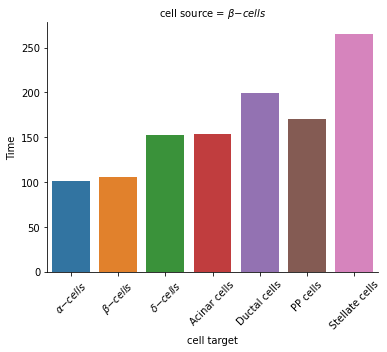

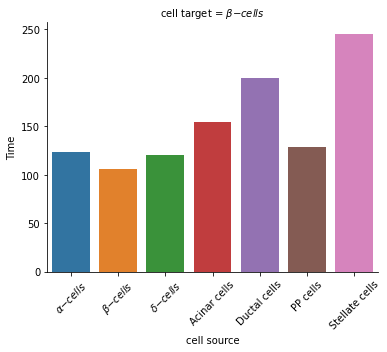

In [51]:
p = sns.catplot(x="cell target", y="Time",
                data=paired_table_nd[paired_table_nd["cell source"] == "$\\beta{-}cells$"],
            col="cell source",kind="bar",col_wrap=3,sharex=False)
for axes in p.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.savefig("interactome_res/figures/figure_6A.pdf")

p = sns.catplot(x="cell source", y="Time",
                data=paired_table_nd[paired_table_nd["cell target"] == "$\\beta{-}cells$"],
            col="cell target",kind="bar",col_wrap=3,sharex=False)
for axes in p.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.savefig("interactome_res/figures/figure_6B.pdf")

#### T2D

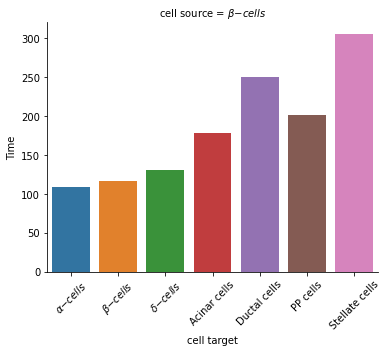

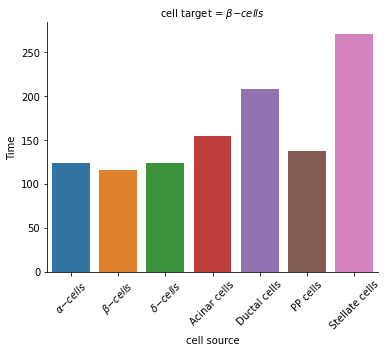

In [52]:
p = sns.catplot(x="cell target", y="Time",
                data=paired_table_t2d[paired_table_t2d["cell source"] == "$\\beta{-}cells$"],
            col="cell source",kind="bar",col_wrap=3,sharex=False)
for axes in p.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.savefig("interactome_res/figures/figure_6C.pdf")

p = sns.catplot(x="cell source", y="Time",
                data=paired_table_t2d[paired_table_t2d["cell target"] == "$\\beta{-}cells$"],
            col="cell target",kind="bar",col_wrap=3,sharex=False)
for axes in p.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.savefig("interactome_res/figures/figure_6D.pdf")

### Distribution of interaction score in ND and T2D beta cell interactomes
The interaction score is variable encoding the average expression of the ligands/receptors of a given interaction. Below the score distributions for ND and T2D beta cell interactomes are reported

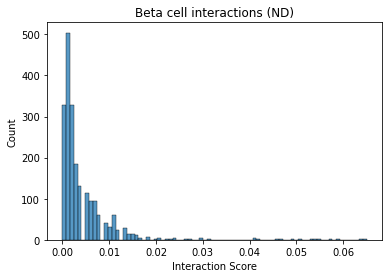

In [53]:
#df_long_nd.value.hist()
sub_beta_nd = df_long_nd[(df_long_nd["cell source"] == "$\\beta{-}cells$")|(df_long_nd["cell target"] == "$\\beta{-}cells$")]
f = sns.histplot(sub_beta_nd.value,bins=80)
#plt.xlim(0,1)
plt.title("Beta cell interactions (ND)")
plt.xlabel(r'Interaction Score')
plt.savefig("/home/bosi/analisi/panalphat2d/figures/figure_6E.pdf")
plt.show()

#sub_beta_nd.value.hist()

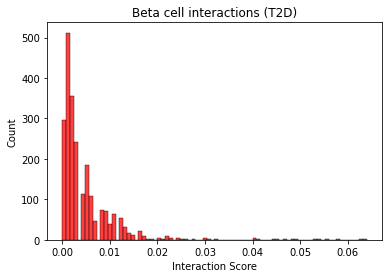

In [54]:
#df_long_t2d.value.hist()
sub_beta_t2d = df_long_t2d[(df_long_t2d["cell source"] == "$\\beta{-}cells$")|(df_long_t2d["cell target"] == "$\\beta{-}cells$")]
f = sns.histplot(sub_beta_t2d.value,bins=80,color="red")
plt.title("Beta cell interactions (T2D)")
plt.xlabel(r'Interaction Score')
plt.savefig("/home/bosi/analisi/panalphat2d/figures/figure_6F.pdf")
plt.show()

### Recover the top changing interactions in beta cells 

In [55]:
beta_t2d = df_long_t2d[(df_long_t2d["cell target"]=="$\\beta{-}cells$") | \
                      (df_long_t2d["cell source"]=="$\\beta{-}cells$")].sort_values(
                            ["value","interacting_pair"],ascending=False)


beta_nd = df_long_nd[(df_long_nd["cell target"]=="$\\beta{-}cells$") | \
                      (df_long_nd["cell source"]=="$\\beta{-}cells$")].sort_values(
                            ["value","interacting_pair"],ascending=False)

In [56]:
beta_t2d["interxn_s"] = beta_t2d[["cell source","id_cp_interaction"]].sum(axis=1)
beta_t2d["interxn_t"] = beta_t2d[["cell source","id_cp_interaction"]].sum(axis=1)
beta_nd["interxn_s"] = beta_nd[["cell source","id_cp_interaction"]].sum(axis=1)
beta_nd["interxn_t"] = beta_nd[["cell source","id_cp_interaction"]].sum(axis=1)

In [57]:
## source
gained_s = beta_t2d[beta_t2d["interxn_t"].isin(
    set(beta_t2d[(beta_t2d["cell source"]=="$\\beta{-}cells$")]["interxn_t"].values).difference(
    set(beta_nd.loc[(beta_nd["cell source"]=="$\\beta{-}cells$")]["interxn_t"].values)))]

lost_s = beta_nd[beta_nd["interxn_t"].isin(
    set(beta_nd[(beta_nd["cell source"]=="$\\beta{-}cells$")]["interxn_t"].values).difference(
    set(beta_t2d.loc[(beta_t2d["cell source"]=="$\\beta{-}cells$")]["interxn_t"].values)))]

## target
gained_t = beta_t2d[beta_t2d["interxn_s"].isin(
    set(beta_t2d[(beta_t2d["cell target"]=="$\\beta{-}cells$")]["interxn_s"].values).difference(
    set(beta_nd.loc[(beta_nd["cell target"]=="$\\beta{-}cells$")]["interxn_s"].values)))]

lost_t = beta_nd[beta_nd["interxn_s"].isin(
    set(beta_nd[(beta_nd["cell target"]=="$\\beta{-}cells$")]["interxn_s"].values).difference(
    set(beta_t2d.loc[(beta_t2d["cell target"]=="$\\beta{-}cells$")]["interxn_s"].values)))]

## both
gained_b = beta_t2d[(beta_t2d["cell source"]=="$\\beta{-}cells$") &
                 (beta_t2d["cell target"]=="$\\beta{-}cells$")][beta_t2d["id_cp_interaction"].isin(
    set(beta_t2d[(beta_t2d["cell source"]=="$\\beta{-}cells$") &
                 (beta_t2d["cell target"]=="$\\beta{-}cells$")]["id_cp_interaction"].values).difference(
    set(beta_nd[(beta_nd["cell source"]=="$\\beta{-}cells$")&
                (beta_nd["cell target"]=="$\\beta{-}cells$")]["id_cp_interaction"].values)))]

lost_b = beta_nd[(beta_nd["cell source"]=="$\\beta{-}cells$") &
                 (beta_nd["cell target"]=="$\\beta{-}cells$")][beta_nd["id_cp_interaction"].isin(
    set(beta_nd[(beta_nd["cell source"]=="$\\beta{-}cells$") &
                 (beta_nd["cell target"]=="$\\beta{-}cells$")]["id_cp_interaction"].values).difference(
    set(beta_t2d.loc[(beta_t2d["cell source"]=="$\\beta{-}cells$")&
                    (beta_t2d["cell target"]=="$\\beta{-}cells$")]["id_cp_interaction"].values)))]

In [58]:
gained_s = gained_s.sort_values("value",ascending=False)
gained_t = gained_t.sort_values("value",ascending=False)
lost_s = lost_s.sort_values("value",ascending=False)
lost_t = lost_t.sort_values("value",ascending=False)

gained_s.to_excel("interactome_res/tables/Supplementary Table 10A.xlsx")
lost_s.to_excel("interactome_res/tables/Supplementary Table 10B.xlsx")
gained_t.to_excel("interactome_res/tables/Supplementary Table 10C.xlsx")
lost_t.to_excel("interactome_res/tables/Supplementary Table 10D.xlsx")

In [59]:
extreme_gained_s = gained_s[gained_s.value >= gained_s.value.quantile(.95)]
extreme_lost_s = lost_s[lost_s.value >= lost_s.value.quantile(.95)]
extreme_gained_t = gained_t[gained_t.value >= gained_t.value.quantile(.95)]
extreme_lost_t = lost_t[lost_t.value >= lost_t.value.quantile(.95)]

for i in [extreme_gained_s,extreme_gained_t,extreme_lost_s,extreme_lost_t]:
    print(i.shape)

(7, 18)
(21, 18)
(1, 18)
(15, 18)
